In [2]:
import pandas as pd
import numpy as np
import torch 
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


In [3]:
df = pd.read_csv("jena_climate_2009_2016.csv")[5::6]
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [4]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [5]:
# correct for windspeeds < 0
df['wv (m/s)'][df['wv (m/s)'] < 0] = 0
df['max. wv (m/s)'][df['max. wv (m/s)'] < 0] = 0

df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

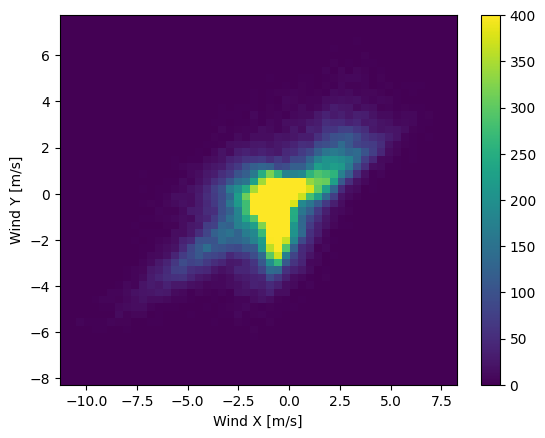

In [6]:
# convert the wind degrees and wind speed to a wind vector

wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')


<Axes: >

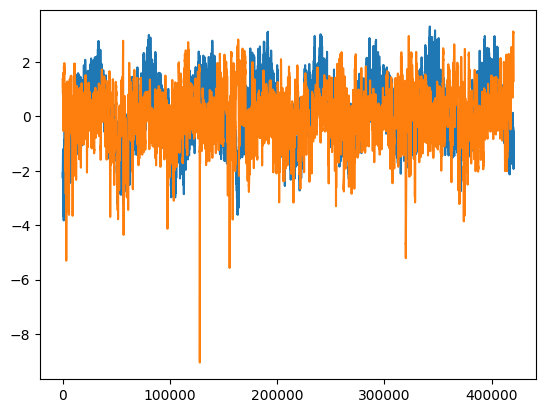

In [7]:
# standardize all numeric features
df = (df-df.mean(axis=0)) / df.std(axis=0)
df["T (degC)"].plot()
df["p (mbar)"].plot()

5    2009-01-01 01:00:00
11   2009-01-01 02:00:00
17   2009-01-01 03:00:00
23   2009-01-01 04:00:00
29   2009-01-01 05:00:00
35   2009-01-01 06:00:00
41   2009-01-01 07:00:00
47   2009-01-01 08:00:00
53   2009-01-01 09:00:00
59   2009-01-01 10:00:00
Name: Date Time, dtype: datetime64[ns]


<BarContainer object of 8 artists>

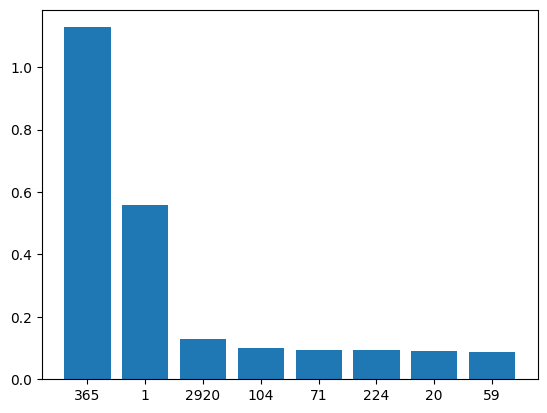

In [8]:
# check for seasonality
from collections import defaultdict

# confirm the data is sampled hourly
print(date_time[0:10])


temp = np.array(df["T (degC)"])
fft = np.fft.fft(temp)

N = len(temp) # length
T = 1 # freq
D = N * T # duration
t = np.linspace(0.0, N*T, N, endpoint=False)
frequency = np.fft.fftfreq(t.size, d=T)

fft = fft[:int(N/2)]
frequency = frequency[:int(N/2)]

# take the highest 10 frequencies and compute their amplitude
max = np.abs(fft).argsort()[::-1][:10]

frequencies = (1.0 / frequency[max]) / 24 # convert from hours to days
magnitudes = np.abs(fft[max]) * 2 / N

#print(frequencies, magnitudes)

cnt = defaultdict(lambda: 0)

for k, v in zip([str(int(x+0.1)) for x in frequencies], magnitudes):
    cnt[k] += v

plt.bar(cnt.keys(), cnt.values())

# we see clearly there is a yearly fundamental and a daily fundamental 
# (2920 days == 8 years - the number of years we have data for)


Text(0.5, 1.0, 'Time of day signal')

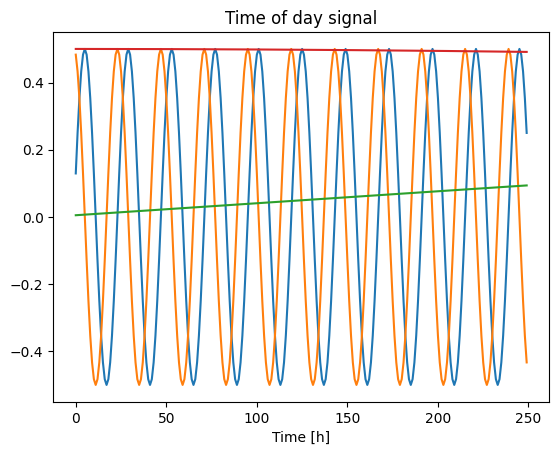

In [9]:
# given the confirmed above, we are going to transform the 
# date / time to sine waves with daily and yearly 

timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

# normalized already
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day)) * 0.5
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day)) * 0.5
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year)) * 0.5
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year)) * 0.5

plt.plot(np.array(df['Day sin'])[:250])
plt.plot(np.array(df['Day cos'])[:250])
plt.plot(np.array(df['Year sin'])[:250])
plt.plot(np.array(df['Year cos'])[:250])

plt.xlabel('Time [h]')
plt.title('Time of day signal')



In [10]:
# timeseries, so no random split

train_df = df[ : int(0.7 * len(df))]
val_df = df[int(0.7 * len(df)) : int(0.9 * len(df))]
test_df = df[int(0.9 * len(df)) : ]


(array([ 0.03674625,  1.36281556,  1.35069869, ..., -0.42169572,
       -0.27100865, -0.42018366]), array([1.58481661, 1.69997223, 1.66673143, 1.04346646, 0.96630033,
       0.92237499, 0.88913419, 0.86301642, 0.72055585, 0.6896894 ]))


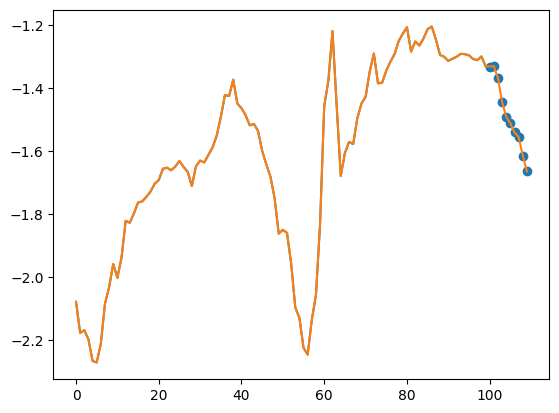

In [11]:
class WindowedDataset(Dataset):
    
    def __init__(self, df, input_window_len, target_len, shift, var_columns, target_columns, transform=None, target_transform=None) -> None:
        super().__init__()
        self.df = df
        self.input_window_len = input_window_len
        self.target_len = target_len
        self.shift = shift
        self.transform = transform
        self.target_transform = target_transform
        self.target_columns = target_columns
        self.var_columns = var_columns

    def get_input_size(self):
        return self.input_window_len * len(self.var_columns)
    
    def get_target_size(self):
        return self.target_len * len(self.target_columns)
    
    def count_channels(self):
        return len(self.var_columns)

    def __len__(self):
        return int((len(self.df) - self.target_len - self.input_window_len) / self.shift)
    
    def __getitem__(self, idx):

        start = idx * self.shift

        variables = np.array(self.df[self.var_columns][start : start + self.input_window_len]).flatten()
        target = np.array(self.df[self.target_columns][start + self.input_window_len : start + self.input_window_len + self.target_len]).flatten()

        if self.transform:
            variables = self.transform(variables)
        if self.target_transform:
            target = self.target_transform(target)


        #print(variables.shape, target.shape)
    
        return variables, target
    
    def plot(self, idx, col_name):

        var_tmp = self.var_columns
        target_tmp = self.target_columns

        self.var_columns = [col_name]
        self.target_columns = [col_name]

        v, t = wds[idx]

        self.var_columns = var_tmp
        self.target_columns = target_tmp

        start = idx * self.shift
        cnt = self.input_window_len + self.target_len

        axis = range(start, start + cnt)

        plt.plot(axis[start : start + self.input_window_len], v)
        plt.scatter(axis[start + self.input_window_len : cnt], t)

    


## test 

wds = WindowedDataset(train_df, 100, 10, 1, df.columns, "T (degC)" )

#print(len(wds))
#print(wds[0])
#print(wds[1])
print(wds[len(wds) - 1])

# the two plots below should be overlapped
wds.plot(0, "T (degC)")
plt.plot(range(0, 110), train_df["T (degC)"][0:110])


In [12]:
# simplest model - take one row, predict next temperature point

def make_dataloader(df, input_window_len, target_len, shift):
    return DataLoader(
        WindowedDataset(
            df, input_window_len, target_len, shift, df.columns, ["T (degC)"],  
            transform=lambda v: torch.tensor(v, dtype=torch.float32),
            target_transform= lambda v: torch.tensor(v, dtype=torch.float32)
        ), 
        batch_size=128, 
        shuffle=True)

train_loader = make_dataloader(train_df, 1, 1, 1)
valid_loader = make_dataloader(val_df, 1, 1, 1)
test_loader = make_dataloader(test_df, 1, 1, 1)

In [13]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))


def create_trainer(dataloader, model, epochs):
    loss_fn = RMSELoss
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    losses = []

    def train():

        size = len(dataloader.dataset)
        model.train()

        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # save losses for plotting
            losses.append(loss.item())

            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    def trainer():
        for i in range(epochs):
            print("Epoch ", i)
            train()
        plt.plot(losses)

    return trainer


In [27]:
class BasicLinear(nn.Module):
    def __init__(self, input_size, target_size):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(input_size, target_size),
        )

    def forward(self, x):
        return self.linear_stack(x)

model = BasicLinear(train_loader.dataset.get_input_size(), train_loader.dataset.get_target_size()).to(device)
print(model)

BasicLinear(
  (linear_stack): Sequential(
    (0): Linear(in_features=19, out_features=1, bias=True)
  )
)


Epoch  0
loss: 0.858611  [  128/49061]
loss: 0.224373  [12928/49061]
loss: 0.136816  [25728/49061]
loss: 0.120857  [38528/49061]
Epoch  1
loss: 0.136919  [  128/49061]
loss: 0.099539  [12928/49061]
loss: 0.110646  [25728/49061]
loss: 0.103187  [38528/49061]
Epoch  2
loss: 0.093823  [  128/49061]
loss: 0.090231  [12928/49061]
loss: 0.080584  [25728/49061]
loss: 0.106071  [38528/49061]


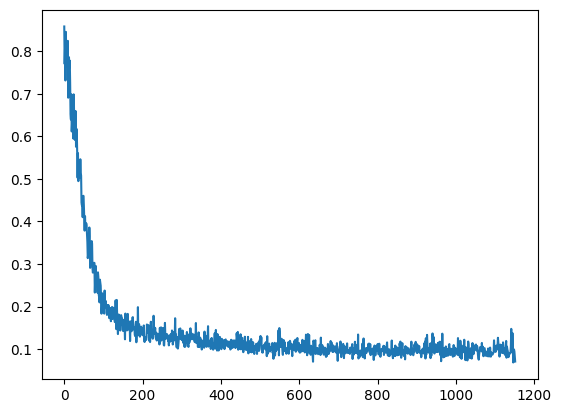

In [28]:
trainer = create_trainer(train_loader, model, 3)
trainer()

In [50]:
# deep learning, dense, given 24h of data, predict 1h in advance,
# stride of 1h

class DNNRegressor(nn.Module):
    def __init__(self, input_size, target_size):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(64, target_size)
        )

    def forward(self, x):
        return self.linear_stack(x)
    

train_loader = make_dataloader(train_df, 24, 1, 1)
model = DNNRegressor(train_loader.dataset.get_input_size(), train_loader.dataset.get_target_size()).to(device)
print(model)
print("Total params: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

DNNRegressor(
  (linear_stack): Sequential(
    (0): Linear(in_features=456, out_features=512, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=64, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)
Total params:  266881


Epoch  0
loss: 1.018386  [  128/49038]
loss: 0.185746  [12928/49038]
loss: 0.199443  [25728/49038]
loss: 0.168153  [38528/49038]
Epoch  1
loss: 0.150633  [  128/49038]
loss: 0.165387  [12928/49038]
loss: 0.176929  [25728/49038]
loss: 0.133728  [38528/49038]
Epoch  2
loss: 0.175674  [  128/49038]
loss: 0.200873  [12928/49038]
loss: 0.155286  [25728/49038]
loss: 0.152027  [38528/49038]


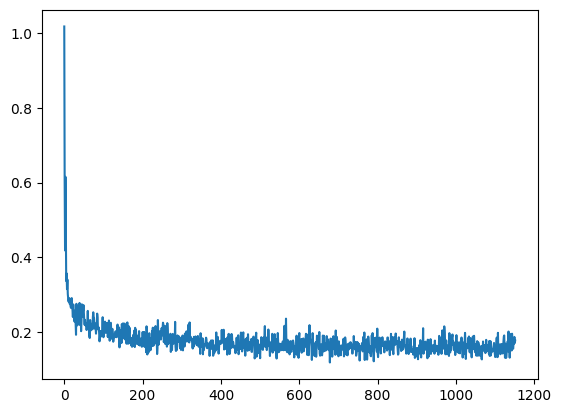

In [47]:
trainer = create_trainer(train_loader, model, 3)
trainer()

In [14]:
# with convolutional NN
class CNNRegressor(nn.Module):
    def __init__(self, in_channels, target_size):
        super().__init__()

        self.in_channels = in_channels

        self.seq_stack = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=256, kernel_size=3, padding='same'),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(output_size=8),
            nn.Flatten(),
            nn.Linear(256 * 8, 128),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(128, target_size)
        )

    def forward(self, x):
        #print(x.shape)
        x = torch.reshape(x, (x.shape[0], int(x.shape[1] / self.in_channels), self.in_channels)).permute(0, 2, 1)
        #print(x.shape)
        return self.seq_stack(x)
    

train_loader = make_dataloader(train_df, 24, 1, 1)
model = CNNRegressor(train_loader.dataset.count_channels(), train_loader.dataset.get_target_size()).to(device)
print(model)
print("Total params: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

CNNRegressor(
  (seq_stack): Sequential(
    (0): Conv1d(19, 256, kernel_size=(5,), stride=(1,), padding=same)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): AdaptiveAvgPool1d(output_size=4)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=256, out_features=64, bias=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)
Total params:  41089


In [15]:
trainer = create_trainer(train_loader, model, 3)
trainer()

Epoch  0


: 

: 

In [41]:
# checking the convolution correctness

x = torch.tensor(
    [
        [1, 2, 3, 4, 5, 6, 7, 8],
        [1, 2, 3, 4, 5, 6, 7, 8],
        [1, 2, 3, 4, 5, 6, 7, 8],
    ], dtype=torch.float32)

x = torch.reshape(x, (x.shape[0], int(x.shape[1] / 2), 2)).permute(0, 2, 1)
print(x.numpy())


[[[1. 3. 5. 7.]
  [2. 4. 6. 8.]]

 [[1. 3. 5. 7.]
  [2. 4. 6. 8.]]

 [[1. 3. 5. 7.]
  [2. 4. 6. 8.]]]
